<a href="https://colab.research.google.com/github/shabayadletzh/Final-Project/blob/main/Final_Project_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

In this notebook, I build and validate the dataset that will be used for the forecasting model by combining multiple real world signals into a single monthly panel per game. I start by extracting historical monthly player counts for a selected list of live service and multiplayer games from SteamCharts, then I enrich that core time series with additional signals that could explain changes in activity. I use the Steam News API to collect each game’s news posts and convert them into a monthly update intensity feature using a simple keyword rule that captures patches, seasons, events, and battle pass style content. I also pull Google Trends data to capture broader popularity and attention over time. After collecting these sources, I merge everything into a continuous monthly timeline for each game, handle missing values in a controlled way by filling or forward filling external signals and interpolating the target in log space only when needed, and create forecasting features such as deterministic calendar and event indicators for major seasonal periods and rolling summaries of updates and trends that are shifted so they only use information available before the prediction month. Finally, I do basic exploration and quality checks including coverage per game, summary statistics, sanity plots, missing values, duplicates, continuity of monthly records, and outlier flagging to confirm the panel is consistent and safe for modeling. The purpose of the notebook is to produce a clean and reproducible processed dataset that captures both player behavior and plausible drivers, and then export it so the modeling notebook can train and evaluate forecasts without repeating the scraping.

In [ ]:
!pip -q install lxml tqdm pytrends

### Importing libraries for the project

In [ ]:
import os
import time
import random
import json
from pathlib import Path
from io import StringIO

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import requests
from tqdm import tqdm

from pytrends.request import TrendReq

### Configuration, folders, and the 20-game scope list (Steam app_id → name).

In [ ]:
# Reproducibility for any random operations
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Project folder structure
DATA_DIR = Path("data")
RAW_DIR = DATA_DIR / "raw"           # cached HTML from SteamCharts
PROCESSED_DIR = DATA_DIR / "processed"  # final dataset exported for modeling
EXT_DIR = DATA_DIR / "external"      # cached Steam News JSON and Trends CSV

# Create directories if they do not exist
for d in [RAW_DIR, PROCESSED_DIR, EXT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Data start date: keeps a reasonable historical window and makes external signals more consistent
START_DATE = pd.Timestamp("2018-01-01")

# Polite scraping settings
REQUEST_TIMEOUT = 20
SLEEP_SECONDS = 1.0
USER_AGENT = "Mozilla/5.0 (compatible; class-project/1.0; +https://example.com)"

# Steam app_id -> game name
# This list focuses on multiplayer / live-service titles where seasonal events and updates make sense.
GAMES = {
    570: "Dota 2",
    730: "Counter-Strike 2",
    578080: "PUBG: BATTLEGROUNDS",
    1172470: "Apex Legends",
    271590: "Grand Theft Auto V",
    359550: "Tom Clancy's Rainbow Six Siege",
    440: "Team Fortress 2",
    230410: "Warframe",
    1085660: "Destiny 2",
    238960: "Path of Exile",
    381210: "Dead by Daylight",
    252490: "Rust",
    236390: "War Thunder",
    105600: "Terraria",
    892970: "Valheim",
    304930: "Unturned",
    394360: "Hearts of Iron IV",
    346110: "ARK: Survival Evolved",
    550: "Left 4 Dead 2",
    1086940: "Baldur's Gate 3",
}

print("Games in scope:", len(GAMES))
assert len(GAMES) == 20

Games in scope: 20


### Caching helpers: fetch HTML and JSON once, then reuse cached files.

In [ ]:
def fetch_html(url: str, cache_path: Path) -> str:
    """
    Fetch HTML with on-disk cache.

    - If cached file exists: use it (fast + reproducible).
    - Else: download via requests, save to disk, sleep briefly (polite scraping).
    """
    if cache_path.exists():
        return cache_path.read_text(encoding="utf-8", errors="ignore")

    r = requests.get(url, headers={"User-Agent": USER_AGENT}, timeout=REQUEST_TIMEOUT)
    r.raise_for_status()

    html = r.text
    cache_path.write_text(html, encoding="utf-8", errors="ignore")

    time.sleep(SLEEP_SECONDS)
    return html


def json_dump(path: Path, obj: dict):
    """Save a Python dict to JSON on disk using the standard json library."""
    path.write_text(json.dumps(obj), encoding="utf-8", errors="ignore")


def json_load(path: Path) -> dict:
    """Load JSON from disk into a Python dict."""
    return json.loads(path.read_text(encoding="utf-8", errors="ignore"))


def fetch_json(url: str, cache_path: Path) -> dict:
    """
    Fetch JSON with on-disk cache.

    Used for Steam News API responses:
    - If cached: reuse.
    - Else: download JSON, save to disk, sleep briefly.
    """
    if cache_path.exists():
        return json_load(cache_path)

    r = requests.get(url, headers={"User-Agent": USER_AGENT}, timeout=REQUEST_TIMEOUT)
    r.raise_for_status()

    data = r.json()
    json_dump(cache_path, data)

    time.sleep(SLEEP_SECONDS)
    return data

### Scrape SteamCharts monthly player history and clean it into a tidy dataset.

In [ ]:
def parse_steamcharts_monthly_table(html: str) -> pd.DataFrame:
    """
    SteamCharts pages contain multiple HTML tables.
    We locate the monthly history table by requiring columns 'Month' and 'Avg. Players'.
    """
    tables = pd.read_html(StringIO(html))

    monthly = None
    for t in tables:
        cols = [str(c).strip() for c in t.columns]
        if "Month" in cols and "Avg. Players" in cols:
            monthly = t.copy()
            break

    if monthly is None:
        raise ValueError("Monthly table not found (Month / Avg. Players).")

    monthly.columns = [str(c).strip() for c in monthly.columns]
    keep_cols = [c for c in ["Month", "Avg. Players", "Peak Players"] if c in monthly.columns]
    return monthly[keep_cols].copy()


def clean_monthly_table(df: pd.DataFrame, app_id: int, game_name: str) -> pd.DataFrame:
    """
    Convert SteamCharts table into consistent monthly time series.

    Key steps:
    - Parse month strings (e.g., 'July 2012') into a month-start datetime.
    - Convert player counts (remove commas, cast to numeric).
    - Attach app_id and game name for downstream merges.
    """
    out = df.copy()

    # Convert month label to datetime; non-month rows become NaT and are dropped
    out["month"] = pd.to_datetime(out["Month"], format="%B %Y", errors="coerce")
    out = out.dropna(subset=["month"]).copy()

    # Normalize to month-start timestamps
    out["month"] = out["month"].dt.to_period("M").dt.to_timestamp(how="start")

    # Clean numeric columns
    for col in ["Avg. Players", "Peak Players"]:
        if col in out.columns:
            out[col] = out[col].astype(str).str.replace(",", "", regex=False).str.strip()
            out[col] = pd.to_numeric(out[col], errors="coerce")

    # Rename to python-friendly names
    out = out.rename(columns={"Avg. Players": "avg_players", "Peak Players": "peak_players"})

    # Add identifiers
    out["app_id"] = app_id
    out["game"] = game_name

    # Keep canonical columns
    keep = ["app_id", "game", "month", "avg_players"]
    if "peak_players" in out.columns:
        keep.append("peak_players")

    return out[keep].sort_values(["app_id", "month"]).reset_index(drop=True)


# Scrape each game's SteamCharts page and build one combined dataset
rows, failures = [], []

for app_id, name in tqdm(GAMES.items(), desc="SteamCharts scrape"):
    url = f"https://steamcharts.com/app/{app_id}"
    cache = RAW_DIR / f"steamcharts_{app_id}.html"
    try:
        html = fetch_html(url, cache)
        tbl = parse_steamcharts_monthly_table(html)
        rows.append(clean_monthly_table(tbl, app_id, name))
    except Exception as e:
        failures.append((app_id, name, str(e)))

print("Scrape OK:", len(rows), "| Failed:", len(failures))
if failures:
    print("Failure example:", failures[0])

# Combine all games
players_df = pd.concat(rows, ignore_index=True)

# Optional: restrict timeframe
players_df = players_df[players_df["month"] >= START_DATE].copy()

display(players_df.head())
print("Player rows:", len(players_df), "| Games:", players_df["app_id"].nunique())

SteamCharts scrape: 100%|██████████| 20/20 [00:00<00:00, 28.38it/s]

Scrape OK: 20 | Failed: 0


,app_id,game,month,avg_players,peak_players
66,570,Dota 2,2018-01-01,486861.91,778627
67,570,Dota 2,2018-02-01,438847.72,779299
68,570,Dota 2,2018-03-01,437262.35,773897
69,570,Dota 2,2018-04-01,430340.94,733214
70,570,Dota 2,2018-05-01,474325.87,844713


Player rows: 1775 | Games: 20


### Build a monthly “update intensity” signal from Steam News API using a simple keyword rule.

In [ ]:
# Keyword list used to label news posts as "update/event-related"
# This is a lightweight proxy for patch cadence / seasonal content.
UPDATE_KEYWORDS = [
    "update", "patch", "season", "battle pass", "battlepass",
    "event", "winter", "christmas", "halloween", "operation",
    "anniversary", "spring", "summer"
]

def news_keyword_hit(text: str) -> int:
    """
    Convert text into a binary signal: 1 if any update keyword appears, else 0.
    """
    if not isinstance(text, str):
        return 0
    t = text.lower()
    return int(any(k in t for k in UPDATE_KEYWORDS))


def fetch_steam_news(app_id: int, count: int = 300) -> pd.DataFrame:
    """
    Pull news posts from Steam News API and aggregate to monthly counts.

    Output:
    - (app_id, month, update_posts) where update_posts is the number of keyword-matched posts.
    """
    url = (
        "https://api.steampowered.com/ISteamNews/GetNewsForApp/v0002/"
        f"?appid={app_id}&count={count}&maxlength=300&format=json"
    )
    cache = EXT_DIR / f"steamnews_{app_id}.json"
    data = fetch_json(url, cache)

    items = data.get("appnews", {}).get("newsitems", [])
    if not items:
        return pd.DataFrame(columns=["app_id", "month", "update_posts"])

    df = pd.DataFrame(items)

    # Steam gives epoch seconds -> datetime
    df["date"] = pd.to_datetime(df["date"], unit="s", errors="coerce")
    df["month"] = df["date"].dt.to_period("M").dt.to_timestamp(how="start")

    # Combine title and contents for matching
    df["text"] = df["title"].fillna("") + " " + df.get("contents", "").fillna("")
    df["is_update"] = df["text"].apply(news_keyword_hit)

    # Monthly sum of "is_update"
    monthly = df.groupby("month", as_index=False)["is_update"].sum()
    monthly = monthly.rename(columns={"is_update": "update_posts"})
    monthly["app_id"] = app_id

    return monthly[["app_id", "month", "update_posts"]]


news_rows = []
for app_id in tqdm(GAMES.keys(), desc="Steam News API"):
    news_rows.append(fetch_steam_news(app_id))

news_df = pd.concat(news_rows, ignore_index=True) if news_rows else pd.DataFrame()
news_df = news_df[news_df["month"] >= START_DATE].copy()

display(news_df.head())
print("News rows:", len(news_df))

Steam News API: 100%|██████████| 20/20 [00:00<00:00, 49.47it/s]


,app_id,month,update_posts
0,570,2022-02-01,8
1,570,2022-03-01,8
2,570,2022-04-01,0
3,570,2022-05-01,3
4,570,2022-06-01,9


News rows: 784


### Fetch monthly Google Trends interest as a simple “popularity proxy” and cache it.

In [ ]:
def fetch_google_trends_monthly(query: str, timeframe: str = "today 5-y") -> pd.DataFrame:
    """
    Download Google Trends interest_over_time and aggregate to monthly average.

    - Caches output per query to keep reruns stable.
    - Returns a DataFrame with columns: month, trend_score.
    """
    cache = EXT_DIR / f"trends_{query.replace(' ', '_').lower()}.csv"
    if cache.exists():
        return pd.read_csv(cache, parse_dates=["month"])

    pytrends = TrendReq(hl="en-US", tz=360)
    pytrends.build_payload([query], timeframe=timeframe)
    it = pytrends.interest_over_time()

    if it.empty:
        return pd.DataFrame(columns=["month", "trend_score"])

    it = it.reset_index().rename(columns={query: "trend_score"})
    it["month"] = it["date"].dt.to_period("M").dt.to_timestamp(how="start")

    monthly = it.groupby("month", as_index=False)["trend_score"].mean()
    monthly.to_csv(cache, index=False)
    return monthly


trend_rows = []
for app_id, name in tqdm(GAMES.items(), desc="Google Trends"):
    try:
        tdf = fetch_google_trends_monthly(name, timeframe="today 5-y")
        tdf["app_id"] = app_id
        trend_rows.append(tdf)
    except Exception as e:
        # Trends sometimes fails due to rate limits; we tolerate missing and fill later.
        print(f"[WARN] Trends failed for {name}: {e}")

trends_df = pd.concat(trend_rows, ignore_index=True) if trend_rows else pd.DataFrame()
trends_df = trends_df[trends_df["month"] >= START_DATE].copy()

display(trends_df.head())
print("Trends rows:", len(trends_df))

Google Trends: 100%|██████████| 20/20 [00:00<00:00, 182.56it/s]


,month,trend_score,app_id
0,2020-12-01,35.666667,570
1,2021-01-01,28.400000,570
2,2021-02-01,27.750000,570
3,2021-03-01,37.250000,570
4,2021-04-01,40.500000,570


Trends rows: 1220


### Create deterministic calendar event features (known in advance, safe for forecasting).

In [ ]:
def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calendar features are deterministic functions of the date:
    - smooth cyclic seasonality via sin/cos
    - coarse event windows via month flags (international major seasonal periods)
    """
    out = df.copy()
    m = out["month"].dt.month

    # Smooth month-of-year encoding
    out["sin_m"] = np.sin(2 * np.pi * m / 12)
    out["cos_m"] = np.cos(2 * np.pi * m / 12)

    # Month-level proxies for major global seasonal periods
    out["ev_winter_holidays"] = m.isin([12, 1]).astype(int)
    out["ev_lunar_new_year"]  = m.isin([1, 2]).astype(int)
    out["ev_valentines"]      = (m == 2).astype(int)
    out["ev_spring_break"]    = m.isin([3, 4]).astype(int)
    out["ev_summer"]          = m.isin([6, 7, 8]).astype(int)
    out["ev_back_to_school"]  = (m == 9).astype(int)
    out["ev_halloween"]       = (m == 10).astype(int)
    out["ev_black_friday"]    = (m == 11).astype(int)

    return out

### Merge players + news + trends into one monthly panel and compute forecast-safe rolling features.

In [ ]:
def build_game_panel(players_df: pd.DataFrame, news_df: pd.DataFrame, trends_df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a complete monthly panel per game with consistent month index.

    Output includes:
    - avg_players (target)
    - update_posts (monthly update keyword counts)
    - trend_score (monthly google trends)
    - calendar features (sin/cos + event flags)
    - rolling summaries shifted by 1 month to avoid look-ahead leakage
    """
    panels = []

    for app_id, g in players_df.groupby("app_id"):
        g = g.sort_values("month").copy()

        # Create a continuous monthly index so each game has explicit missing months
        full_idx = pd.date_range(g["month"].min(), g["month"].max(), freq="MS")
        base = pd.DataFrame({"month": full_idx})
        base["app_id"] = app_id
        base["game"] = g["game"].iloc[0]

        # Attach target
        base = base.merge(g[["month", "avg_players"]], on="month", how="left")

        # Attach update intensity (missing => 0 update posts)
        base = base.merge(news_df[news_df["app_id"] == app_id], on=["app_id", "month"], how="left")
        base["update_posts"] = base["update_posts"].fillna(0)

        # Attach trends (missing => forward-fill, then 0 if still missing)
        base = base.merge(trends_df[trends_df["app_id"] == app_id], on=["app_id", "month"], how="left")
        base["trend_score"] = base["trend_score"].ffill().fillna(0)

        # Fill missing target months by interpolation in log space for stability
        if base["avg_players"].isna().any():
            s = np.log1p(base["avg_players"])
            s = s.interpolate(limit_direction="both")
            base["avg_players"] = np.expm1(s)

        # Add deterministic calendar features
        base = add_calendar_features(base)

        # Rolling summaries (shifted by 1) so month t uses only information available up to t-1
        base["upd_3m"] = base["update_posts"].rolling(3).sum().shift(1).fillna(0)
        base["upd_6m"] = base["update_posts"].rolling(6).sum().shift(1).fillna(0)
        base["tr_3m"]  = base["trend_score"].rolling(3).mean().shift(1).fillna(0)
        base["tr_6m"]  = base["trend_score"].rolling(6).mean().shift(1).fillna(0)

        panels.append(base)

    return pd.concat(panels, ignore_index=True)


full_df = build_game_panel(players_df, news_df, trends_df)

# Restrict to analysis window
full_df = full_df[full_df["month"] >= START_DATE].copy()
full_df = full_df.sort_values(["app_id", "month"]).reset_index(drop=True)

display(full_df.head())
print("Panel rows:", len(full_df), "| Games:", full_df["app_id"].nunique())

,month,app_id,game,avg_players,update_posts,trend_score,sin_m,cos_m,ev_winter_holidays,ev_lunar_new_year,ev_valentines,ev_spring_break,ev_summer,ev_back_to_school,ev_halloween,ev_black_friday,upd_3m,upd_6m,tr_3m,tr_6m
0,2018-01-01,440,Team Fortress 2,53432.10,0.0,0.0,0.500000,8.660254e-01,1,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,2018-02-01,440,Team Fortress 2,37715.11,0.0,0.0,0.866025,5.000000e-01,0,1,1,0,0,0,0,0,0.0,0.0,0.0,0.0
2,2018-03-01,440,Team Fortress 2,36781.88,0.0,0.0,1.000000,6.123234e-17,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0
3,2018-04-01,440,Team Fortress 2,39180.46,0.0,0.0,0.866025,-5.000000e-01,0,0,0,1,0,0,0,0,0.0,0.0,0.0,0.0
4,2018-05-01,440,Team Fortress 2,38847.02,0.0,0.0,0.500000,-8.660254e-01,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0


Panel rows: 1775 | Games: 20


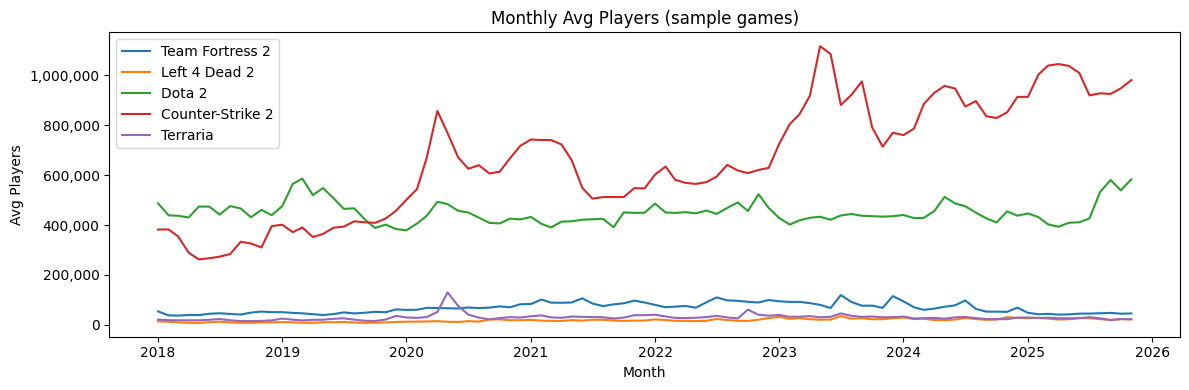

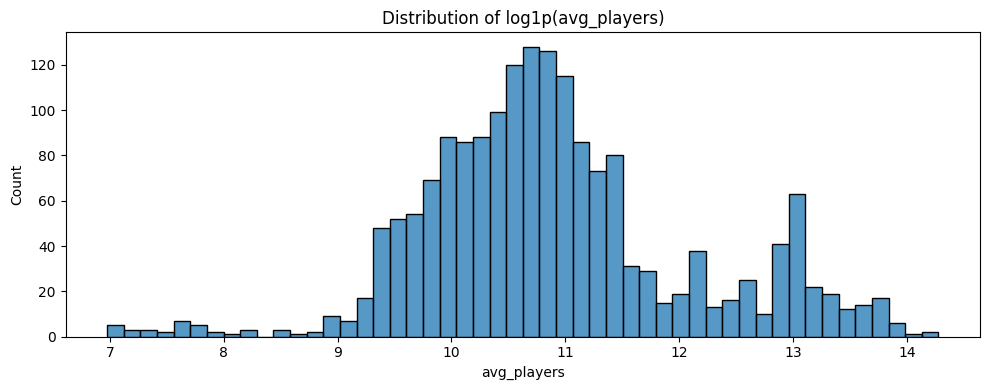

In [ ]:
# Simple time series plot for a few games (avoid scientific notation on y-axis)
sample_games = full_df["game"].drop_duplicates().tolist()[:5]

plt.figure(figsize=(12, 4))
ax = plt.gca()
for g in sample_games:
    gdf = full_df[full_df["game"] == g].sort_values("month")
    ax.plot(gdf["month"], gdf["avg_players"], label=g)

ax.set_title("Monthly Avg Players (sample games)")
ax.set_xlabel("Month")
ax.set_ylabel("Avg Players")
ax.ticklabel_format(style="plain", axis="y", useOffset=False)  # removes 1e6 scientific offset
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))  # comma formatting
ax.legend()
plt.tight_layout()
plt.show()

# Distribution plot: log transform justification
plt.figure(figsize=(10, 4))
sns.histplot(np.log1p(full_df["avg_players"]), bins=50)
plt.title("Distribution of log1p(avg_players)")
plt.tight_layout()
plt.show()

### Interpretation

Top time-series plot (monthly avg players for a few games): The games operate on very different scales. Counter-Strike 2 and Dota 2 dominate the player counts, while Team Fortress 2, Left 4 Dead 2, and Terraria are much smaller and look “flat” mainly because they are compressed by the shared y-axis. You can also see real shocks and trend changes over time, especially for Counter-Strike 2 (large spikes and step-like increases) and Dota 2 (more stable but still seasonal movement).

Bottom histogram (distribution of log1p(avg_players)): After the log transform, the target looks much more well-behaved and closer to a single broad bell-shaped mass, with a right tail representing very large games. This supports using log1p(avg_players) for modeling because it reduces scale gaps and prevents the biggest games from completely dominating training.

### This section validates that the monthly panel is consistent and model-ready. It checks missing values, duplicates, month continuity per game, suspicious target values, and whether engineered features are safe for forecasting.

In [ ]:
# EDA: Data Quality Checks

# Guard: ensure full_df exists
if "full_df" not in globals():
    raise RuntimeError("full_df is not defined. Run the panel build cell first.")

# Make sure sorting is consistent for all time-based checks
full_df = full_df.sort_values(["app_id", "month"]).reset_index(drop=True)

print("Rows:", len(full_df), "| Games:", full_df["app_id"].nunique(), "| Date range:",
      full_df["month"].min().date(), "->", full_df["month"].max().date())

Rows: 1775 | Games: 20 | Date range: 2018-01-01 -> 2025-11-01


### Check missing values and dtypes.

In [ ]:
# Count missing values per column
na_counts = full_df.isna().sum().sort_values(ascending=False)
display(na_counts[na_counts > 0])

# Quick dtypes check (model expects numeric features + datetime month)
display(full_df.dtypes)

# If anything critical is missing, fail early (better than training on broken data)
critical_cols = ["app_id", "game", "month", "avg_players", "upd_3m", "tr_3m", "sin_m", "cos_m"]
missing_critical = [c for c in critical_cols if c not in full_df.columns]
if missing_critical:
    raise ValueError(f"Critical columns missing: {missing_critical}")

if full_df["avg_players"].isna().any():
    raise ValueError("avg_players still contains NaNs. Interpolation/filling did not complete.")

,0


,0
month,datetime64[ns]
app_id,int64
game,object
avg_players,float64
update_posts,float64
trend_score,float64
sin_m,float64
cos_m,float64
ev_winter_holidays,int64
ev_lunar_new_year,int64


### Ensure there is exactly one row per game per month

In [ ]:
dups = full_df.duplicated(subset=["app_id", "month"]).sum()
print("Duplicate (app_id, month) rows:", dups)

if dups > 0:
    # Show a small sample of duplicates for debugging
    display(full_df[full_df.duplicated(subset=["app_id", "month"], keep=False)]
            .sort_values(["app_id", "month"]).head(20))
    raise ValueError("Found duplicate (app_id, month) rows. Fix before modeling.")

Duplicate (app_id, month) rows: 0


### Check that each game has a continuous monthly timeline (no gaps).

In [ ]:
issues = []
for app_id, g in full_df.groupby("app_id"):
    g = g.sort_values("month")
    # Expected monthly starts sequence
    expected = pd.date_range(g["month"].min(), g["month"].max(), freq="MS")
    if len(expected) != len(g):
        issues.append((app_id, g["game"].iloc[0], len(g), len(expected)))

if issues:
    issues_df = pd.DataFrame(issues, columns=["app_id", "game", "rows_in_panel", "expected_months"])
    print("[WARN] Some games are not continuous monthly panels (should be fixed by build_game_panel).")
    display(issues_df.sort_values("expected_months", ascending=False).head(20))
else:
    print("All games have continuous monthly panels (no gaps).")

All games have continuous monthly panels (no gaps).


### Catch impossible or suspicious values (negative, zeros, extreme spikes).

In [ ]:
# Negative players is impossible
neg = (full_df["avg_players"] < 0).sum()
print("Negative avg_players:", neg)
if neg > 0:
    display(full_df[full_df["avg_players"] < 0].head(10))
    raise ValueError("Found negative avg_players values.")

# Zeros are suspicious for popular games; allow but flag
zeros = (full_df["avg_players"] == 0).sum()
print("Zero avg_players:", zeros)
if zeros > 0:
    display(full_df[full_df["avg_players"] == 0][["game","month","avg_players"]].head(10))

# Outliers per game via robust z-score on log scale (simple + stable)
tmp = full_df.copy()
tmp["log_players"] = np.log1p(tmp["avg_players"])

outlier_rows = []
for app_id, g in tmp.groupby("app_id"):
    med = g["log_players"].median()
    mad = np.median(np.abs(g["log_players"] - med)) + 1e-8  # robust scale
    z = (g["log_players"] - med) / (1.4826 * mad)           # approx robust z
    extreme = g[np.abs(z) > 6]                               # very extreme only
    if len(extreme) > 0:
        outlier_rows.append(extreme.assign(robust_z=z.loc[extreme.index]))

if outlier_rows:
    outliers_df = pd.concat(outlier_rows, ignore_index=True)
    print("[INFO] Extreme outliers detected (robust z > 6). Review but do not auto-delete.")
    display(outliers_df[["game","month","avg_players","robust_z"]].sort_values("robust_z", ascending=False).head(20))
else:
    print("No extreme outliers detected by robust z-score threshold.")

Negative avg_players: 0
Zero avg_players: 0
[INFO] Extreme outliers detected (robust z > 6). Review but do not auto-delete.


,game,month,avg_players,robust_z
1,Valheim,2021-02-01,210302.24,7.965266
2,Valheim,2021-03-01,178435.44,7.408442
0,Terraria,2020-05-01,129808.62,6.429708


Note: even though there are extreme outliers, they don't seem to be unnatural and we can them leave as it is.

### Verify forecast-safe design: rolling exogenous features should not use same-month information (they should be shifted by 1).

In [ ]:
# update_posts and trend_score are raw signals; rolling summaries should be shifted by 1 month
# We validate shifting by checking: upd_3m at time t should equal sum(update_posts in t-3..t-1)
# Do this for a small sample game to keep it simple and fast.

sample_app = full_df["app_id"].iloc[0]
g = full_df[full_df["app_id"] == sample_app].sort_values("month").reset_index(drop=True)

# Compute expected shifted rolling values directly from raw update_posts
expected_upd_3m = g["update_posts"].rolling(3).sum().shift(1).fillna(0)
expected_tr_3m  = g["trend_score"].rolling(3).mean().shift(1).fillna(0)

# Compare with stored columns
diff_upd = np.max(np.abs(g["upd_3m"].values - expected_upd_3m.values))
diff_tr  = np.max(np.abs(g["tr_3m"].values  - expected_tr_3m.values))

print("Max abs diff (upd_3m vs expected):", diff_upd)
print("Max abs diff (tr_3m  vs expected):", diff_tr)

# If these differ a lot, it usually indicates missing shift and potential leakage
if diff_upd > 1e-6 or diff_tr > 1e-6:
    print("[WARN] Rolling features mismatch expected shifted rolling computation. Possible leakage risk.")
    display(g[["month","update_posts","upd_3m","trend_score","tr_3m"]].head(15))
else:
    print("Rolling features match shifted computations (forecast-safe).")

Max abs diff (upd_3m vs expected): 0.0
Max abs diff (tr_3m  vs expected): 0.0
Rolling features match shifted computations (forecast-safe).


### Summarize coverage and feature ranges to ensure inputs are in reasonable numeric scales

In [ ]:
# Coverage: how much history each game contributes
coverage = full_df.groupby("game")["month"].agg(["min", "max", "count"]).sort_values("count", ascending=False)
display(coverage)

# Feature scale snapshot (helps catch values that are accidentally huge or constant)
feature_cols = ["upd_3m","upd_6m","tr_3m","tr_6m","sin_m","cos_m",
                "ev_winter_holidays","ev_halloween","ev_black_friday"]
scale_summary = full_df[feature_cols].describe().T[["min","mean","std","max"]]
display(scale_summary)

# Quick correlation check (log target vs main exog summaries)
# This is not causal—just a sanity check that signals are not completely random.
corr_df = full_df.assign(log_players=np.log1p(full_df["avg_players"]))[["log_players","upd_3m","tr_3m","upd_6m","tr_6m"]].corr()
display(corr_df)

,min,max,count
game,,,
ARK: Survival Evolved,2018-01-01,2025-11-01,95
Counter-Strike 2,2018-01-01,2025-11-01,95
Dota 2,2018-01-01,2025-11-01,95
Dead by Daylight,2018-01-01,2025-11-01,95
Unturned,2018-01-01,2025-11-01,95
Team Fortress 2,2018-01-01,2025-11-01,95
Grand Theft Auto V,2018-01-01,2025-11-01,95
Hearts of Iron IV,2018-01-01,2025-11-01,95
PUBG: BATTLEGROUNDS,2018-01-01,2025-11-01,95


,min,mean,std,max
upd_3m,0.0,4.384789,7.723600,89.000000
upd_6m,0.0,8.130704,13.196197,134.000000
tr_3m,0.0,22.713515,23.475073,83.250000
tr_6m,0.0,21.994086,22.951479,79.080556
sin_m,-1.0,-0.002103,0.710682,1.000000
cos_m,-1.0,-0.008038,0.703865,1.000000
ev_winter_holidays,0.0,0.157746,0.364606,1.000000
ev_halloween,0.0,0.085070,0.279065,1.000000
ev_black_friday,0.0,0.085634,0.279901,1.000000


,log_players,upd_3m,tr_3m,upd_6m,tr_6m
log_players,1.000000,0.039394,0.025465,0.042071,0.019722
upd_3m,0.039394,1.000000,0.248017,0.928366,0.242380
tr_3m,0.025465,0.248017,1.000000,0.268634,0.979120
upd_6m,0.042071,0.928366,0.268634,1.000000,0.272109
tr_6m,0.019722,0.242380,0.979120,0.272109,1.000000


### Save the processed dataset for the modeling notebook (EDA → Modeling handoff).

In [ ]:
# This file is the contract between notebooks:
# - EDA produces it
# - Modeling consumes it
out_path = PROCESSED_DIR / "monthly_panel_with_exog.csv"
full_df.to_csv(out_path, index=False)

print("Saved processed dataset to:", out_path)
print("Rows:", len(full_df), "| Columns:", len(full_df.columns))

Saved processed dataset to: data/processed/monthly_panel_with_exog.csv
Rows: 1775 | Columns: 20
